# The Goal

Lyft wants to create some kind of semantic segmentation network - my idea is to have a GAN generate it. Let's see how that works.


## Looking at the data
The dataset provided has some examples - let's take a look. I'll also try and create a function to make the resulting segmented map look more visibly striking.

In [1]:
#First, load up things we're definitely going to need
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Load up datasets
from glob import glob

dataset = {
    "images": [],
    "maps": []
}

def get_filenames(folder):
    return glob(folder + "/*.png")

dataset['images'] = get_filenames("./data/Train/CameraRGB/")
dataset['maps'] = get_filenames("./data/Train/CameraSeg/")

print("There are {} total camera shots, and {} total maps.".format(len(dataset['images']), len(dataset['maps'])))

There are 1000 total camera shots, and 1000 total maps.


The values in the map are in the red channel of the dataset image, so (value, 0, 0) per pixel. Here I convert those to colors based on what value, so its easier to see (otherwise everything is dim shades of dark red)

In [3]:
#Make a map more colorful
def convertToColor(value):
    colors = [
        (255, 255, 255),   #0
        (255, 0, 0),      #1
        (0, 255, 0),      #2
        (0, 0, 255),      #3
        (255, 255, 0),    #4
        (127, 0, 255),    #5
        (51, 255, 51),    #6
        (255, 0, 127),    #7
        (127, 127, 127),  #8
        (0, 0, 0),        #9
        (0, 255, 255),  #10
        (0, 0, 100),      #11
        (100, 0, 0),      #12
    ]
    return colors[value[0]]

def colorizeMap(img):
    return [list( map(convertToColor, row) ) for row in img]
    
    

Using images 778, 375, and 478


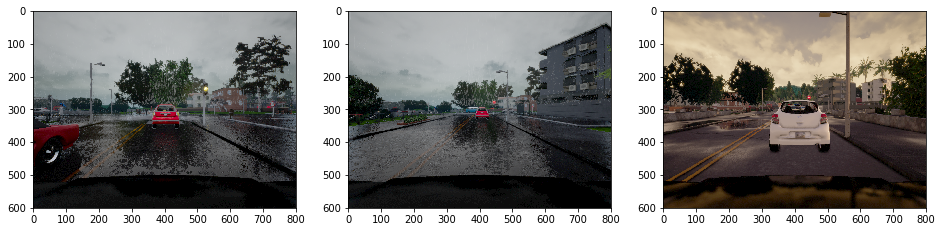

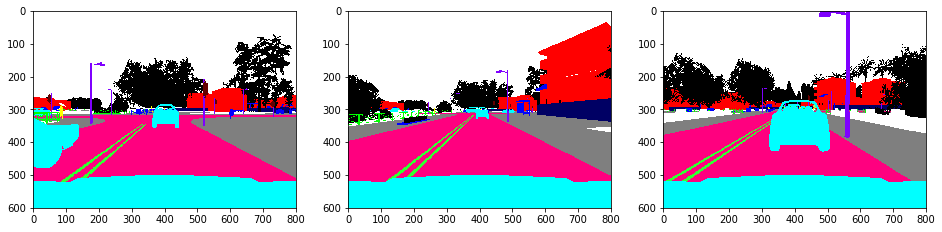

In [4]:
### Load up a couple of random examples of each
from random import randint

chosenImages = []

for i in range(0,3):
    chosenImages.append(randint(0, len(dataset['images'])))
    
print("Using images {}, {}, and {}".format(chosenImages[0], chosenImages[1], chosenImages[2]))

fig = plt.figure(figsize=(16,12))
for i in range(0, 3):
    fig.add_subplot(1, 3,i + 1)
    img = cv2.imread(dataset['images'][chosenImages[i]])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
fig = plt.figure(figsize=(16,12))
for i in range(0, 3):
    fig.add_subplot(1, 3,i + 1)
    img = cv2.imread(dataset['maps'][chosenImages[i]])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = colorizeMap(img)
    plt.imshow(img)

## Toy Network

Before we dive too deep, let's see if a network can even get started on this. No need to optimize if core ideas are wrong.

The idea is to create a GAN that will generate these maps directly. The generator will generate examples, the discriminator will determine if the map fits or not.

In [5]:
import tensorflow as tf
#Check GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
print('TensorFlow Version: {}'.format(tf.__version__))

Default GPU Device: /device:GPU:0
TensorFlow Version: 1.6.0


In [11]:
# Saving image dimensions for easier reference (makes it easier if we resize later)
image_dims = (800, 600)

In [12]:
# Some placeholder variables
#Generator takes in an RGB image, and outputs a map
generator_input = tf.placeholder(tf.float32, (None, image_dims[0], image_dims[1], 3), name="generator_input")

#Discriminator takes an RGB image and a map, set up as a 4 channel image - we're dropping the two unused channels for now
discriminator_input = tf.placeholder(tf.float32, (None, image_dims[0], image_dims[1], 4), name="discriminator_input")

learning_rate = tf.placeholder(tf.float32, name="learning_rate")

## Models

In [13]:
#Here we define the discriminator network
def discriminator(input_data, reuse=False, alpha=0.2, training=True):
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        #Layer 0 - Convolutional
        conv_layer_0 = tf.layers.conv2d(input_data, 64, 5, strides=2, padding='same')
        conv_layer_0 = tf.maximum(conv_layer_0 * alpha, conv_layer_0) # leaky relu
        
        #Layer 1 - Convolutional
        conv_layer_1 = tf.layers.conv2d(conv_layer_0, 128, 5, strides=2, padding='same')
        conv_layer_1 = tf.layers.batch_normalization(conv_layer_1, training=training)
        conv_layer_1 = tf.maximum(conv_layer_1 * alpha, conv_layer_1) # leaky relu
               
        #Layer 2 - Convolutional
        conv_layer_2 = tf.layers.conv2d(conv_layer_1, 128, 5, strides=2, padding='same')
        conv_layer_2 = tf.layers.batch_normalization(conv_layer_2, training=training)
        conv_layer_2 = tf.maximum(conv_layer_2 * alpha, conv_layer_2) # leaky relu
        
        #Layer 3 - Dense
        flattened = tf.contrib.layers.flatten(layer_2)
        logits = tf.layers.dense(flattened, 1)
        output = tf.sigmoid(logits)
        
    return output, logits

In [17]:
def generator(image, training=True, alpha=0.2):
    #Dense layer - 100x75x512
    dense = tf.layers.dense(image, 100*75*512)
    dense = tf.reshape(dense, (-1, 100, 75, 512))
    dense = tf.layers.batch_normalization(dense, training=training)
    dense = tf.maximum(dense * alpha, dense)

    #Transposed Convolution Layer 1 200x150x256
    conv_1 = tf.layers.conv2d_transpose(dense, 256, 6, strides=2, padding='same')
    conv_1 = tf.layers.batch_normalization(conv_1, training=training)
    conv_1 = tf.maximum(conv_1 * alpha, conv_1)

    #Transposed Convolution Layer 2 400x300x128
    conv_2 = tf.layers.conv2d_transpose(conv_1, 128, 6, strides=2, padding='same')
    conv_2 = tf.layers.batch_normalization(conv_2, training=training)
    conv_2 = tf.maximum(conv_2 * alpha, conv_2)
    
    # Output Layer 800x600x1
    logits = tf.layers.conv2d_transpose(conv_2, 1, 6, strides=2, padding='same')

    output = tf.tanh(logits)

    return output

## Loss

Generate a loss function for real and generated inputs, then off of the generated inputs create a loss function for the generator.

In [19]:
def model_loss(discriminator_input, generator_input):
    generator_model = generator(generator_input)
    discriminator_model_real, disc_logits_real = discriminator(discriminator_input, reuse=False)
    discriminator_model_fake, d_logits_fake = discriminator(generator_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_real,
            labels=tf.ones.like(discriminator_model_real)
        )
    )
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits = d_logits_fake,
            labels=tf.zeros.like(discriminator_model_fake)
        )
    )
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(discriminator_fake)
        )
    )
    
    return d_loss, g_loss

## Optimization
Create optimizers for trainnig both networks

In [ ]:
def model_optimizers(d_loss, g_loss, learning_rate, beta1):
    